<a href="https://colab.research.google.com/github/kaustuvm-git/DMQL-NIK/blob/main/Stock_Prediction_CSE560.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

import numpy as np
import pandas as pd
import yfinance as yf
import pandas as pd
from matplotlib.pyplot import *

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 6.3 MB 7.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=96438ee39a7df137b3768244f2ae2495bda05b1583037f6a101fc4fd9d0f8681
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
Mounted at /content/drive


In [ ]:
# Fetch Stock data from Yahoo Finance

def dump_stock_data(name=None):
  msft = yf.Ticker(name)

  df_hist = msft.history(period='max')
  df_hist['date_'] = df_hist.index
  df_hist.index = range(len(df_hist))

  df_hist.to_csv('df_stock_hist.csv', index=False)
  !mv df_stock_hist.csv '/content/drive/My Drive/'

In [ ]:
dump_stock_data(name='GOOGL')

In [2]:
# Load df

df_hist = pd.read_csv('/content/drive/My Drive/df_stock_hist.csv')[['date_', 'Open']]
df_hist = df_hist.sort_values(by='date_', ascending=True)

In [3]:
# Creating Lagged Features
df_hist = pd.concat([df_hist.Open]+[df_hist.Open.shift(-_) for _ in range(1, 61)], axis=1)
df_hist.columns = ['Open_{}'.format(_) for _ in range(len(df_hist.columns))]
df_hist.rename(columns={'Open_60': 'target_price'}, inplace=True)
df_hist = df_hist.dropna(axis=0)

In [4]:
df_hist.head()

,Open_0,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,Open_8,Open_9,Open_10,Open_11,Open_12,Open_13,Open_14,Open_15,Open_16,Open_17,Open_18,Open_19,Open_20,Open_21,Open_22,Open_23,Open_24,Open_25,Open_26,Open_27,Open_28,Open_29,Open_30,Open_31,Open_32,Open_33,Open_34,Open_35,Open_36,Open_37,Open_38,Open_39,Open_40,Open_41,Open_42,Open_43,Open_44,Open_45,Open_46,Open_47,Open_48,Open_49,Open_50,Open_51,Open_52,Open_53,Open_54,Open_55,Open_56,Open_57,Open_58,Open_59,target_price
0,50.050049,50.555557,55.430431,55.675674,52.532532,52.527527,54.104103,52.692692,51.201202,51.401402,49.644646,50.525524,50.555557,50.420422,51.316315,50.850849,53.368366,53.778778,55.335335,56.226227,57.267265,58.533535,59.964966,58.758759,59.479481,60.530533,59.839840,60.710712,63.413414,65.015015,65.465462,67.692696,67.397400,68.843842,68.528526,69.429428,68.568565,67.287285,71.731735,70.575577,72.537537,71.671669,75.325325,74.089088,72.272270,85.355354,88.288284,93.263260,91.451454,93.433434,99.544548,96.871872,99.489487,99.189186,94.314316,91.081078,85.550552,87.137138,85.420418,84.649651,92.707710
1,50.555557,55.430431,55.675674,52.532532,52.527527,54.104103,52.692692,51.201202,51.401402,49.644646,50.525524,50.555557,50.420422,51.316315,50.850849,53.368366,53.778778,55.335335,56.226227,57.267265,58.533535,59.964966,58.758759,59.479481,60.530533,59.839840,60.710712,63.413414,65.015015,65.465462,67.692696,67.397400,68.843842,68.528526,69.429428,68.568565,67.287285,71.731735,70.575577,72.537537,71.671669,75.325325,74.089088,72.272270,85.355354,88.288284,93.263260,91.451454,93.433434,99.544548,96.871872,99.489487,99.189186,94.314316,91.081078,85.550552,87.137138,85.420418,84.649651,92.707710,90.315315
2,55.430431,55.675674,52.532532,52.527527,54.104103,52.692692,51.201202,51.401402,49.644646,50.525524,50.555557,50.420422,51.316315,50.850849,53.368366,53.778778,55.335335,56.226227,57.267265,58.533535,59.964966,58.758759,59.479481,60.530533,59.839840,60.710712,63.413414,65.015015,65.465462,67.692696,67.397400,68.843842,68.528526,69.429428,68.568565,67.287285,71.731735,70.575577,72.537537,71.671669,75.325325,74.089088,72.272270,85.355354,88.288284,93.263260,91.451454,93.433434,99.544548,96.871872,99.489487,99.189186,94.314316,91.081078,85.550552,87.137138,85.420418,84.649651,92.707710,90.315315,88.838837
3,55.675674,52.532532,52.527527,54.104103,52.692692,51.201202,51.401402,49.644646,50.525524,50.555557,50.420422,51.316315,50.850849,53.368366,53.778778,55.335335,56.226227,57.267265,58.533535,59.964966,58.758759,59.479481,60.530533,59.839840,60.710712,63.413414,65.015015,65.465462,67.692696,67.397400,68.843842,68.528526,69.429428,68.568565,67.287285,71.731735,70.575577,72.537537,71.671669,75.325325,74.089088,72.272270,85.355354,88.288284,93.263260,91.451454,93.433434,99.544548,96.871872,99.489487,99.189186,94.314316,91.081078,85.550552,87.137138,85.420418,84.649651,92.707710,90.315315,88.838837,84.594597
4,52.532532,52.527527,54.104103,52.692692,51.201202,51.401402,49.644646,50.525524,50.555557,50.420422,51.316315,50.850849,53.368366,53.778778,55.335335,56.226227,57.267265,58.533535,59.964966,58.758759,59.479481,60.530533,59.839840,60.710712,63.413414,65.015015,65.465462,67.692696,67.397400,68.843842,68.528526,69.429428,68.568565,67.287285,71.731735,70.575577,72.537537,71.671669,75.325325,74.089088,72.272270,85.355354,88.288284,93.263260,91.451454,93.433434,99.544548,96.871872,99.489487,99.189186,94.314316,91.081078,85.550552,87.137138,85.420418,84.649651,92.707710,90.315315,88.838837,84.594597,85.230232


In [5]:
# Train-Test Split
df_hist['bins'] = pd.qcut(df_hist.target_price, 10).astype('str')

X_train, X_test, y_train, y_test = train_test_split(df_hist.drop(columns=['bins', 'target_price'], axis=1), df_hist.target_price, test_size=0.2, shuffle=True, stratify=df_hist.bins, random_state=42)


In [6]:
# Calculate Mean and STD for each column in Train data
mean_list = list()
std_list = list()

target_mean = y_train.mean()
target_std = y_train.std()

for col_ in X_train.columns:
  mean_list.append(X_train[col_].mean())
  std_list.append(X_train[col_].std())

In [7]:
# Scale Data
for _, col_ in enumerate(X_train.columns):
  X_train[col_+'_scaled'] = X_train[col_].apply(lambda x: (x - mean_list[_])/std_list[_])
  X_test[col_+'_scaled'] = X_test[col_].apply(lambda x: (x - mean_list[_])/std_list[_])

y_train_scaled = y_train.apply(lambda x: (x - target_mean)/target_std)
y_test_scaled = y_test.apply(lambda x: (x - target_mean)/target_std)

In [8]:
# Prepare X-y data
X_train = X_train[[_ for _ in X_train.columns if '_scaled' in _]]
X_test = X_test[[_ for _ in X_test.columns if '_scaled' in _]]

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train_scaled.to_numpy()
y_test = y_test_scaled.to_numpy()

In [9]:
# Converting to 3-D tensor
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [10]:
# Condition for Early Stopping
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.0040, verbose=2):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [ ]:
# LSTM Model Architecture
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1),
               activity_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.25))
model.add(LSTM(units = 128, return_sequences = True,
               activity_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.25))
model.add(LSTM(units = 128, return_sequences = True,
               activity_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.25))
model.add(LSTM(units = 128, activity_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.25))
model.add(Dense(units = 1))

model.compile(optimizer='adam', loss = 'mean_squared_error')
cb = [EarlyStoppingByLossVal(monitor='val_loss', value=0.0040, verbose=2)]
model.fit(X_train, y_train, epochs = 1000, validation_split=0.2, batch_size = 128, verbose=2, callbacks=cb)
model.save('/content/drive/My Drive/LSTM_GOOGLE.h5')

Epoch 1/1000
22/22 - 9s - loss: 1.9032 - val_loss: 0.7115
Epoch 2/1000
22/22 - 1s - loss: 0.4794 - val_loss: 0.3486
Epoch 3/1000
22/22 - 1s - loss: 0.2859 - val_loss: 0.2445
Epoch 4/1000
22/22 - 1s - loss: 0.2134 - val_loss: 0.1963
Epoch 5/1000
22/22 - 1s - loss: 0.1734 - val_loss: 0.1815
Epoch 6/1000
22/22 - 1s - loss: 0.1515 - val_loss: 0.1421
Epoch 7/1000
22/22 - 1s - loss: 0.1308 - val_loss: 0.1292
Epoch 8/1000
22/22 - 1s - loss: 0.1169 - val_loss: 0.1077
Epoch 9/1000
22/22 - 1s - loss: 0.0952 - val_loss: 0.0861
Epoch 10/1000
22/22 - 1s - loss: 0.0862 - val_loss: 0.0881
Epoch 11/1000
22/22 - 1s - loss: 0.0796 - val_loss: 0.0692
Epoch 12/1000
22/22 - 1s - loss: 0.0700 - val_loss: 0.1007
Epoch 13/1000
22/22 - 1s - loss: 0.0849 - val_loss: 0.0691
Epoch 14/1000
22/22 - 1s - loss: 0.0624 - val_loss: 0.0649
Epoch 15/1000
22/22 - 1s - loss: 0.0541 - val_loss: 0.0675
Epoch 16/1000
22/22 - 1s - loss: 0.0532 - val_loss: 0.0517
Epoch 17/1000
22/22 - 1s - loss: 0.0614 - val_loss: 0.0510
Epoch 

In [12]:
# Loading Saved Model
import tensorflow
model = tensorflow.keras.models.load_model('/content/drive/My Drive/LSTM_GOOGLE.h5')

In [13]:
# Predictions
predictions = model.predict(X_test)
predictions = [predictions[_][0] for _ in range(len(predictions))]
y_test_actual = [(_*target_std)+target_mean for _ in y_test]
y_test_predicted = [(_*target_std)+target_mean for _ in predictions]

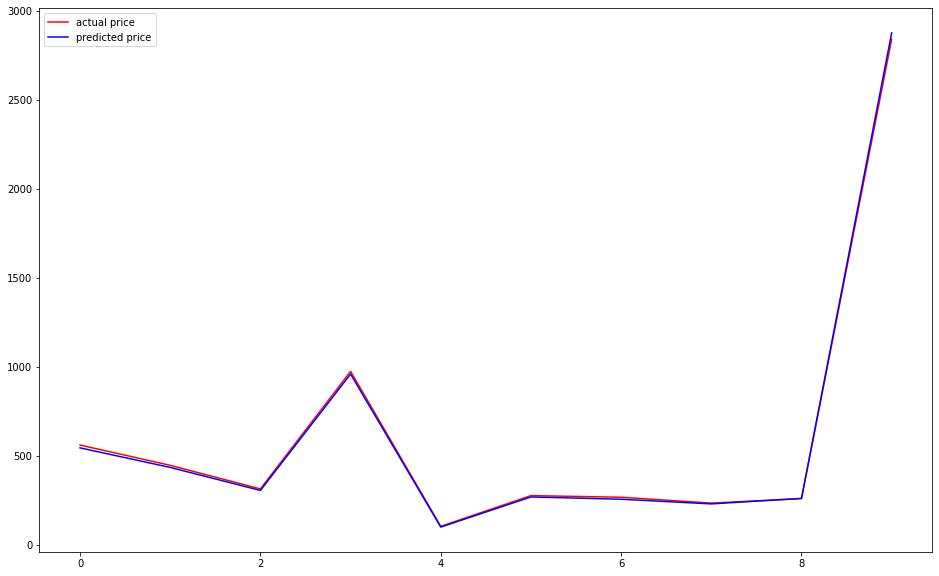

In [17]:
figure(figsize=(16, 10))
plot(y_test_actual[:10], color='r', label='actual price')
plot(y_test_predicted[:10], color='b', label='predicted price')
legend()